In [55]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, MaxPool2D

In [3]:
# data prep.
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("Train images:", x_train.shape)
print("Train labels:", y_train.shape)

Train images: (60000, 28, 28, 1)
Train labels: (60000,)


In [4]:
# ref: https://github.com/HenningBuhl/VQ-VAE_Keras_Implementation/blob/master/VQ_VAE_Keras_MNIST_Example.ipynb
class VQVAELayer(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_embeddings, commitment_cost,
                 initializer='uniform', epsilon=1e-10, name='vqvae', **kwargs):
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.initializer = initializer
        super(VQVAELayer, self).__init__(**kwargs)
        
    def get_config(self):
        cfg = super().get_config()
        return cfg   
    
    def build(self, input_shape):
        # Add embedding weights.
        self.w = self.add_weight(name='embedding',
                                 shape=(self.embedding_dim, self.num_embeddings),
                                 initializer=self.initializer,
                                 trainable=True)

        # Finalize building.
        super(VQVAELayer, self).build(input_shape)

    def call(self, x):
        # Flatten input except for last dimension.
        flat_inputs = tf.reshape(x, (-1, self.embedding_dim))

        # Calculate distances of input to embedding vectors.
        distances = (tf.reduce_sum(flat_inputs**2, axis=1, keepdims=True)
                     - 2 * tf.matmul(flat_inputs, self.w)
                     + tf.reduce_sum(self.w ** 2, axis=0, keepdims=True))

        # Retrieve encoding indices.
        encoding_indices = tf.argmax(-distances, axis=1)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        encoding_indices = tf.reshape(encoding_indices, tf.shape(x)[:-1])
        quantized = self.quantize(encoding_indices)
        
        return quantized, encoding_indices

    @property
    def embeddings(self):
        return self.w

    def quantize(self, encoding_indices):
        w = tf.transpose(self.embeddings.read_value())
        return tf.nn.embedding_lookup(w, encoding_indices)

In [73]:
def mse_loss(ground_truth, predictions):
    mse_loss = tf.reduce_mean((ground_truth - predictions)**2, name="mse_loss")
    return mse_loss
    
def latent_loss(dummy_ground_truth, outputs):
    del dummy_ground_truth
    z_e, z_q = tf.split(outputs, 2, axis=-1)
    vq_loss = tf.reduce_mean((tf.stop_gradient(z_e) - z_q)**2)
    commit_loss = tf.reduce_mean((z_e - tf.stop_gradient(z_q))**2)
    latent_loss = tf.identity(vq_loss + 0.25 * commit_loss, name="latent_loss")
    return latent_loss  

In [74]:
def create_vqvqe_model(embedding_dim, num_embeddings=8, commitment_cost=0.25):
    inp = tf.keras.Input(shape=(28, 28, 1))
    
    #encoder
    x = Conv2D(64, 3, padding='same', activation='relu')(inp)
    x = MaxPool2D(padding='same')(x)
    x = Conv2D(embedding_dim, 3, padding='same', activation='relu')(x)
    x = MaxPool2D(padding='same')(x)
    
    #quantizer
    z_e = x
    z_q, encoding_indices = VQVAELayer(embedding_dim, num_embeddings, commitment_cost)(z_e)
    codes = tf.stack([z_e, z_q], axis=-1, name='latent')
    straight_through = tf.keras.layers.Lambda(lambda x : x[0] + tf.stop_gradient(x[1] - x[0]))
    x = straight_through([z_e, z_q])
    
    #decoder
    x = Conv2DTranspose(embedding_dim, 3, strides=(2, 2), padding='same', activation='relu')(x)
    x = Conv2DTranspose(64, 3, strides=(2, 2), padding='same', activation='relu')(x)
    x = Conv2DTranspose(1, 1, strides=(1, 1), activation='sigmoid', padding='same', name='output')(x)
    
    model = tf.keras.Model(inp, [x, codes]) 
    model.compile(optimizer='adam', loss=[mse_loss, latent_loss], metrics={'output': 'mae'})
    model.summary()

    return model 

model = create_vqvqe_model(embedding_dim=128)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 64)   640         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 128)  73856       max_pooling2d_2[0][0]            
____________________________________________________________________________________________

In [7]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_output_loss', min_delta=0, patience=3)
model.fit(x_train, x_train,
          validation_data=(x_test, x_test),
          batch_size=256, 
          epochs=60, 
          callbacks=[early_stopping_callback])

Epoch 1/60
235/235 [==============================] - 26s 86ms/step - loss: 0.2741 - output_loss: 0.1012 - tf.stack_loss: 0.1729 - output_mae: 0.2199 - val_loss: 1.6754 - val_output_loss: 0.0438 - val_tf.stack_loss: 1.6316 - val_output_mae: 0.1036
Epoch 2/60
235/235 [==============================] - 19s 81ms/step - loss: 1.8306 - output_loss: 0.0444 - tf.stack_loss: 1.7862 - output_mae: 0.1014 - val_loss: 0.5028 - val_output_loss: 0.0364 - val_tf.stack_loss: 0.4664 - val_output_mae: 0.0916
Epoch 3/60
235/235 [==============================] - 20s 83ms/step - loss: 0.4429 - output_loss: 0.0344 - tf.stack_loss: 0.4086 - output_mae: 0.0862 - val_loss: 0.4350 - val_output_loss: 0.0307 - val_tf.stack_loss: 0.4043 - val_output_mae: 0.0776
Epoch 4/60
235/235 [==============================] - 19s 82ms/step - loss: 0.2330 - output_loss: 0.0268 - tf.stack_loss: 0.2062 - output_mae: 0.0698 - val_loss: 0.1063 - val_output_loss: 0.0211 - val_tf.stack_loss: 0.0852 - val_output_mae: 0.0598
Epoch 5/

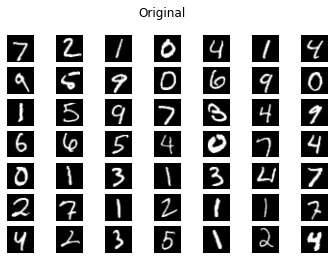

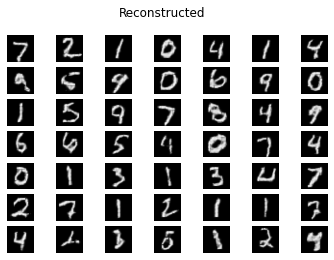

In [72]:
def img_grid(imgs, rows, cols, title):
    fig = plt.figure()
    for i, j in np.ndindex(rows, cols):
        plt.subplot(rows, cols, i*rows+j+1)
        plt.imshow(np.repeat(imgs[i*rows+j], 3, -1))
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

cols = 7
rows = 7
inp_x = x_test[:cols*rows]
pred_x, ebd = model.predict(inp_x)
img_grid(inp_x, rows, cols, 'Original')
img_grid(pred_x, rows, cols, 'Reconstructed')